In [10]:
# Add 'src' directory to Python path for imports to work
import sys
import os

# Add the project root directory to Python path
# This works whether running from notebooks/ or project root
project_root = os.path.abspath('..')  # Go up one level from notebooks/
sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Import environments
from src.environments import BanditEnvironment, GeneralCostRewardEnvironment

# Import algorithms  
from src.algorithms import UCB_B1, UCB_M1, UCB_B2, UCB_B2C, BaseBanditAlgorithm


# Budget-Constrained Multi-Armed Bandits: Simulation Tutorial

This script provides a step-by-step tutorial on simulating and analyzing budget-constrained multi-armed bandit algorithms, based on the paper "Budget-Constrained Bandits over General Cost and Reward Distributions" by Cayci, Eryilmaz, and Srikant.

The goal is to understand how different bandit algorithms (UCB-B1, UCB-M1, UCB-B2, UCB-B2C) perform under a total cost budget, where each arm pull incurs a random cost and yields a random reward. We will use synthetic data generated by a flexible environment that supports various cost-reward distributions.



## 1. Project Setup and Imports

First, we need to import the necessary classes and functions from our project structure. Ensure your project is set up as follows (or adjust import paths accordingly):

````
├── src/
│   ├── algorithms/
│   │   ├── ... (UCB algorithms, base_bandit_algorithm.py)
│   ├── environments/
│   │   ├── ... (bandit_environment.py, general_cost_reward_env.py)
│   └── utils/
│       ├── ... (estimators.py)
├── notebooks/
│   └── analysis.ipynb  (this file)
└── ... (other project files)
````

## 2. Defining Environment and Algorithm Parameters

We'll define the characteristics of our bandit arms and the parameters for the UCB algorithms. We'll set up configurations for Gaussian, Bounded Uniform, and Heavy-Tailed distributions to demonstrate the environment's flexibility and the algorithms' target scenarios.

### Arm Configurations

Each arm is defined by a dictionary specifying its `name`, `type` of distribution, and `params`. The `params` include `mean_X` and `mean_R` (expected cost and reward, crucial for optimal rate calculation) and distribution-specific parameters (e.g., variance, correlation, min/max values for uniform, Pareto/Lognormal parameters).

For algorithms like `UCB_B2` and `UCB_B2C` which assume bounded costs/rewards, we explicitly include `M_X` and `M_R` (maximum bounds for cost and reward) in the `params`.

In [11]:

# Arm Configurations for different distribution types
# Ensure M_X and M_R are included for bounded types, as expected by UCB-B2/B2C
ARM_CONFIGS_GAUSSIAN = [
    {"name": "Arm 0 (Gaussian - Lower Rate)", "type": "gaussian", "params": {"mean_X": 1.0, "mean_R": 2.0, "var_X": 0.1, "var_R": 0.2, "cov_XR": 0.05, "M_X": 5.0, "M_R": 5.0}}, # M_X, M_R are upper bounds on magnitude
    {"name": "Arm 1 (Gaussian - Higher Rate)", "type": "gaussian", "params": {"mean_X": 1.1, "mean_R": 2.5, "var_X": 0.15, "var_R": 0.25, "cov_XR": 0.08, "M_X": 5.0, "M_R": 5.0}}, # Rate = 2.5/1.1 = 2.27
]

ARM_CONFIGS_BOUNDED = [
    {"name": "Arm 0 (Bounded - Uncorrelated)", "type": "bounded_uniform", "params": {"min_X": 0.5, "max_X": 1.5, "min_R": 1.0, "max_R": 3.0, "correlation": 0.0, "mean_X": 1.0, "mean_R": 2.0, "var_X": (1.0)**2/12, "var_R": (2.0)**2/12, "cov_XR": 0.0, "M_X": 1.5, "M_R": 3.0}}, # M_X=max_X, M_R=max_R
    {"name": "Arm 1 (Bounded - Correlated)", "type": "bounded_uniform", "params": {"min_X": 0.8, "max_X": 1.8, "min_R": 1.2, "max_R": 2.5, "correlation": 0.5, "mean_X": 1.3, "mean_R": 1.85, "var_X": (1.0)**2/12, "var_R": (1.3)**2/12, "cov_XR": 0.05, "M_X": 1.8, "M_R": 2.5}}, # Approx rate 1.85/1.3 = 1.42
]

# Note: Heavy-tailed distribution parameters are conceptual for simulation purposes.
# The `var_X`, `var_R`, `cov_XR` for heavy-tailed are for algorithms that assume knowledge
# of these (like UCB-B1/M1), even if they are just estimates or derived from some assumed underlying process.
ARM_CONFIGS_HEAVY_TAILED = [
    {"name": "Arm 0 (Heavy-tailed - Low variance)", "type": "heavy_tailed", "params": {"mean_X": 1.5, "mean_R": 3.0, "alpha_pareto_X": 3.0, "loc_pareto_X": 1.0, "mean_lognormal_R": 1.0, "sigma_lognormal_R": 0.5, "correlation": 0.0, "var_X": 1.0, "var_R": 1.0, "cov_XR": 0.0, "M_X": 100.0, "M_R": 100.0}}, # Use very large M_X, M_R as bounds for heavy-tails conceptually for algos expecting them
    {"name": "Arm 1 (Heavy-tailed - High variance)", "type": "heavy_tailed", "params": {"mean_X": 1.2, "mean_R": 2.8, "alpha_pareto_X": 2.5, "loc_pareto_X": 0.8, "mean_lognormal_R": 1.2, "sigma_lognormal_R": 0.6, "correlation": 0.2, "var_X": 1.5, "var_R": 1.2, "cov_XR": 0.1, "M_X": 100.0, "M_R": 100.0}}, # Rate = 2.33
]

print("Arm configurations defined.")


Arm configurations defined.


### Algorithm Parameters

These are common parameters used across the UCB-type algorithms, such as exploration rates and stability constants.

In [12]:

ALGORITHM_PARAMS = {
    "alpha": 2.1,        # Exploration parameter for UCB algorithms
    "L": 0.5,            # Parameter for UCB-B1 (L=0.5 for Gaussian, L=2 for bounded)
    "b_min_cost": 0.01,  # Small constant to prevent division by zero for empirical mean of cost
    "omega_bar": 2.0,    # Upper bound on omega_k, used in UCB-B2C's M_Z calculation
}

# Simulation parameters
BUDGET = 1000.0
NUM_SIMULATION_RUNS = 5 # Increased for a slightly more stable average in this tutorial

print("Algorithm and simulation parameters defined.")

"""
### Algorithms to Simulate

We'll set up a dictionary mapping algorithm names to their respective classes and the arm configurations they are best suited for. This helps organize our simulation runs.
"""

ALGORITHMS_TO_SIMULATE = {
    "UCB-B1 (Gaussian)": {"class": UCB_B1, "arm_configs": ARM_CONFIGS_GAUSSIAN},
    "UCB-M1 (Heavy-tailed)": {"class": UCB_M1, "arm_configs": ARM_CONFIGS_HEAVY_TAILED},
    "UCB-B2 (Bounded - Uncorrelated)": {"class": UCB_B2, "arm_configs": ARM_CONFIGS_BOUNDED}, # UCB-B2 for uncorrelated bounded
    "UCB-B2C (Bounded - Correlated)": {"class": UCB_B2C, "arm_configs": ARM_CONFIGS_BOUNDED}, # UCB-B2C for correlated bounded
}

print("Algorithms to simulate defined.")

Algorithm and simulation parameters defined.
Algorithms to simulate defined.


## 3. Simulation Logic

This section contains the core simulation loop. For each algorithm and for a specified number of runs:

1.  **Initialize Environment**: A `GeneralCostRewardEnvironment` is created with the relevant arm configurations and a seed for reproducibility of each run.
2.  **Optimal Static Policy**: The expected reward of the optimal static policy (`r* * B`) is calculated. This serves as the benchmark for regret calculation.
3.  **Initialize Algorithm**: The chosen bandit algorithm is instantiated and reset for a fresh start.
4.  **Arm Pull Loop**: The algorithm repeatedly selects an arm, pulls it from the environment (getting a random cost and reward), and updates its internal state, until the total accumulated cost exceeds the `BUDGET`.
5.  **Record Results**: For each run, the cumulative reward, total pulls, and regret are recorded.
"""


In [13]:

all_results = defaultdict(list)

print(f"--- Starting Simulation for Budget B={BUDGET} ---")
print(f"Running {NUM_SIMULATION_RUNS} run(s) per algorithm.")

for algo_name, algo_info in ALGORITHMS_TO_SIMULATE.items():
    AlgoClass = algo_info["class"]
    arm_configs = algo_info["arm_configs"]
    num_arms = len(arm_configs)

    print(f"\nRunning Algorithm: {algo_name}")

    cumulative_rewards_per_run = []
    cumulative_regrets_per_run = []
    total_pulls_per_run = []

    for run_idx in range(NUM_SIMULATION_RUNS):
        # Initialize environment for each run to ensure fresh starts and unique random seeds
        # The seed ensures reproducibility for each individual simulation run.
        env = GeneralCostRewardEnvironment(num_arms=num_arms, arm_configs=arm_configs, seed=42 + run_idx) #

        # The optimal static policy pulls k* until the budget is depleted. 
        # Its total reward is roughly r* * B + O(1). 
        optimal_static_reward_expected = env.get_optimal_reward_rate() * BUDGET

        # Initialize algorithm instance for the current run
        algorithm_instance = AlgoClass(num_arms=num_arms, arm_configs=arm_configs, algorithm_params=ALGORITHM_PARAMS)
        algorithm_instance.reset() # Ensure algorithm state is clean

        current_total_cost = 0.0
        current_total_reward = 0.0
        epoch = 0 # Represents 'n' in the paper, total number of pulls

        # Simulate arm pulls until the budget is depleted
        # The reward corresponding to the final epoch during which the budget is depleted is gathered. 
        while current_total_cost <= BUDGET:
            epoch += 1
            
            # Select an arm using the algorithm's strategy
            chosen_arm = algorithm_instance.select_arm(current_total_cost, epoch)
            
            # Pull the chosen arm from the environment
            cost, reward = env.pull_arm(chosen_arm)

            # Update the algorithm's internal state with observed cost and reward
            algorithm_instance.update_state(chosen_arm, cost, reward)

            # Accumulate total cost and reward
            current_total_cost += cost
            current_total_reward += reward
        
        # Record results for this run
        cumulative_rewards_per_run.append(current_total_reward)
        total_pulls_per_run.append(epoch)
        
        # Calculate regret for this run: Regret = E[REW_opt(B)] - E[REW_pi(B)]. 
        # We use the optimal static policy's expected reward as E[REW_opt(B)], noting its O(1) optimality gap. 
        regret_for_run = optimal_static_reward_expected - current_total_reward
        cumulative_regrets_per_run.append(regret_for_run)

    # Aggregate results for this algorithm over all runs
    all_results["Algorithm"].append(algo_name)
    all_results["Budget"].append(BUDGET)
    all_results["Optimal_Static_Reward_Expected"].append(optimal_static_reward_expected)
    all_results["Avg_Reward"].append(np.mean(cumulative_rewards_per_run))
    all_results["Std_Reward"].append(np.std(cumulative_rewards_per_run))
    all_results["Avg_Regret"].append(np.mean(cumulative_regrets_per_run))
    all_results["Std_Regret"].append(np.std(cumulative_regrets_per_run))
    all_results["Avg_Pulls"].append(np.mean(total_pulls_per_run))
    all_results["Std_Pulls"].append(np.std(total_pulls_per_run))

print("Simulation complete!")

--- Starting Simulation for Budget B=1000.0 ---
Running 5 run(s) per algorithm.

Running Algorithm: UCB-B1 (Gaussian)

Running Algorithm: UCB-M1 (Heavy-tailed)

Running Algorithm: UCB-B2 (Bounded - Uncorrelated)

Running Algorithm: UCB-B2C (Bounded - Correlated)
Simulation complete!


## 4. Analyzing Results

After running the simulations, we can analyze the performance of each algorithm. We'll present the average cumulative reward, average regret, and average total pulls for each algorithm under the given budget.


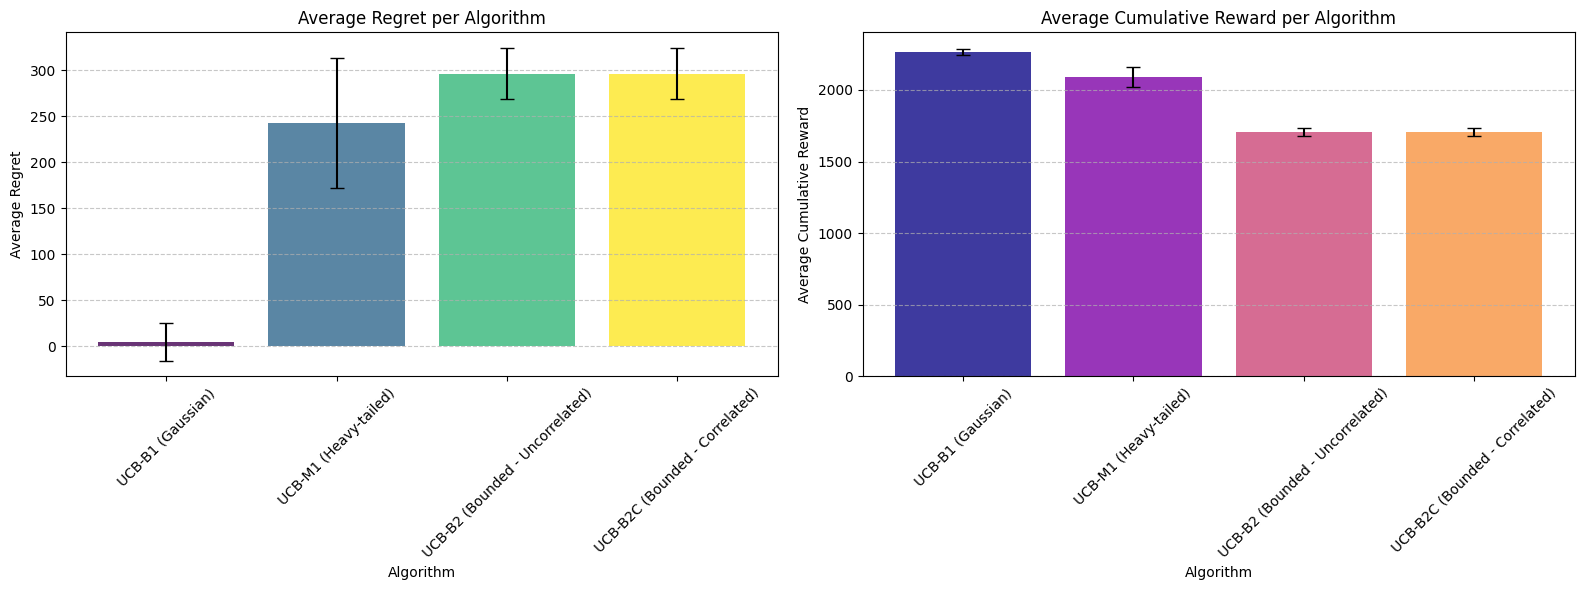


=== ALGORITHM PERFORMANCE SUMMARY ===
Budget: $1000

🎯 UCB-B1 (Gaussian)
   📈 Avg Reward: 2,267.88 ± 20.62
   📉 Avg Regret: 4.85 ± 20.62
   🎯 Avg Pulls:  919
   ⭐ Efficiency: 99.8% of optimal

🎯 UCB-M1 (Heavy-tailed)
   📈 Avg Reward: 2,090.99 ± 70.26
   📉 Avg Regret: 242.34 ± 70.26
   🎯 Avg Pulls:  671
   ⭐ Efficiency: 89.6% of optimal

🎯 UCB-B2 (Bounded - Uncorrelated)
   📈 Avg Reward: 1,703.83 ± 27.80
   📉 Avg Regret: 296.17 ± 27.80
   🎯 Avg Pulls:  885
   ⭐ Efficiency: 85.2% of optimal

🎯 UCB-B2C (Bounded - Correlated)
   📈 Avg Reward: 1,703.83 ± 27.80
   📉 Avg Regret: 296.17 ± 27.80
   🎯 Avg Pulls:  885
   ⭐ Efficiency: 85.2% of optimal

✅ Analysis complete! The plots show algorithm performance with error bars.


In [16]:
# Additional Analysis: Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average Regret with error bars
algorithms = results_df['Algorithm']
regrets = results_df['Avg_Regret']
regret_stds = results_df['Std_Regret']

bars1 = ax1.bar(algorithms, regrets, yerr=regret_stds, capsize=5, alpha=0.8, 
               color=['#440154', '#31688e', '#35b779', '#fde725'])
ax1.set_title('Average Regret per Algorithm')
ax1.set_ylabel('Average Regret')
ax1.set_xlabel('Algorithm')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Average Cumulative Reward with error bars
rewards = results_df['Avg_Reward']
reward_stds = results_df['Std_Reward']

bars2 = ax2.bar(algorithms, rewards, yerr=reward_stds, capsize=5, alpha=0.8,
               color=['#0d0887', '#7e03a8', '#cc4778', '#f89441'])
ax2.set_title('Average Cumulative Reward per Algorithm')
ax2.set_ylabel('Average Cumulative Reward')
ax2.set_xlabel('Algorithm')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Summary table in a more readable format
print("\n=== ALGORITHM PERFORMANCE SUMMARY ===")
print(f"Budget: ${BUDGET:.0f}")
print("=" * 80)

for _, row in results_df.iterrows():
    algo_name = row['Algorithm']
    avg_reward = row['Avg_Reward']
    std_reward = row['Std_Reward']
    avg_regret = row['Avg_Regret']
    std_regret = row['Std_Regret']
    avg_pulls = row['Avg_Pulls']
    optimal_reward = row['Optimal_Static_Reward_Expected']
    
    print(f"\n🎯 {algo_name}")
    print(f"   📈 Avg Reward: {avg_reward:,.2f} ± {std_reward:.2f}")
    print(f"   📉 Avg Regret: {avg_regret:,.2f} ± {std_regret:.2f}")
    print(f"   🎯 Avg Pulls:  {avg_pulls:.0f}")
    print(f"   ⭐ Efficiency: {(avg_reward/optimal_reward)*100:.1f}% of optimal")

print("\n" + "=" * 80)
print("✅ Analysis complete! The plots show algorithm performance with error bars.")
